In [1]:
import pandas as pd
import numpy as np

from textblob import TextBlob
from utility import *
import spacy
nlp = spacy.load("en_core_web_sm") # English Model
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS # stop words
# spacy_stopwords.remove('not') # words to keep

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline

RANDOM_STATE = 42

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Skyrim_Reviews.csv', usecols=['review'])
data.head()

,review
0,"This is the game the never, ever ends. I picke..."
1,Ruined my life. Five stars.
2,I was stacking books on a shelf in my house in...
3,"Best game I ever bought. In this game, you'll ..."
4,Playing Skyrim is like masturbating. Feels goo...


## Text Preprocess

In [3]:
corpus = normalise_text(data['review'], All =True, remove_digit=True, stopword=spacy_stopwords)

## Count Vector

In [79]:
from sklearn.feature_extraction.text import CountVectorizer

count_vector = CountVectorizer(tokenizer = tokenize, ngram_range=(1,1), min_df=5, lowercase=True)
corpus_count_vec = count_vector.fit_transform(corpus)

In [80]:
corpus_vec = pd.DataFrame(corpus_count_vec.toarray(), columns=count_vector.get_feature_names())

In [81]:
corpus_vec = corpus_vec.iloc[:,9:]
corpus_vec.head()

,aaa,abandon,ability,able,absolute,absolutely,absorb,absurd,abuse,accept,...,yield,yo,young,youtube,zaan,zenimax,zero,zin,zindro,zombie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,3,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Topic Models

Topic modeling is a form of dimensionality reduction. Rather than representing a text T in its feature space as a word requency vector, we can represent the text in its topic space as topic weight vector.

In [37]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
n_topics = 5

In [13]:
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print(f'Topic: {idx}')
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

In [14]:
def document_topics(DTM):
    return [np.argmax(doc) for doc in DTM]

### NMF (Non-Negative Matrix Factorization)

A matrix V is factorized into two matrices W and H, with the property that all three matrices have no negative elements.

E.g. Let the input matrix be V with 10000 rows and 500 columns where we have 500 documents indexed by 10000 words. It follows that a column vector v in V represents a document.

Assume we ask the algorithm to find 10 features(Topics) in order to generate a features matrix W with 10000 rows and 10 columns and a coefficients matrix H with 10 rows and 500 columns.

The product of W and H is a matrix with 10000 rows and 500 columns, the same shape as the input matrix V and, if the factorization worked, it is a reasonable approximation to the input matrix V.

In [82]:
nmf_model = NMF(n_components=n_topics, solver='mu', random_state=RANDOM_STATE)
W = nmf_model.fit_transform(corpus_vec)
H = nmf_model.components_
print(f'(NO_DOCUMENTS, NO_TOPICS) - {W.shape}, (NO_TOPICS, NO_WORDS) - {H.shape}')

(NO_DOCUMENTS, NO_TOPICS) - (7165, 5), (NO_TOPICS, NO_WORDS) - (5, 3276)


In [83]:
print_topics(nmf_model, count_vector, 3)

Topic: 0
[('funny', 14.462938738595762), ('nordic', 4.669816378083711), ('skeleton', 4.554737405878323)]
Topic: 1
[('misc', 10.419635264806484), ('patch', 4.029608968746222), ('nordic', 2.544165854377219)]
Topic: 2
[('skeleton', 4.204275417285048), ('dovahkiin', 3.7341540762063135), ('nordic', 3.2419373606952706)]
Topic: 3
[('modders', 7.990232025672688), ('fps', 7.936097654064759), ('owe', 0.08025941367853621)]
Topic: 4
[('nordic', 7.480477119971531), ('thank', 3.033060761652455), ('finish', 2.65476788695276)]


In [84]:
data['nmf_topic'] = pd.Series(document_topics(W))
data.head()

,review,nmf_topic,lsa_topic,lda_topic
0,"This is the game the never, ever ends. I picke...",0,0,0
1,Ruined my life. Five stars.,2,3,0
2,I was stacking books on a shelf in my house in...,2,3,0
3,"Best game I ever bought. In this game, you'll ...",0,0,3
4,Playing Skyrim is like masturbating. Feels goo...,0,0,1


## LSA (Latent Semantic Analysis)

LSA learns latent topics by performing a matrix decomposition on the document-term matrix using Singular value decomposition.

Singular value decomposition is a method of decomposing a matrix into three other matrices:

M=UΣV*

- M is an m×m matrix (Document-Term Matrix)
- U is a m×n left singular matrix (Term Topic Matrix)
- Σ is a n×n diagonal matrix with non-negative real numbers. (Topic Topic Matrix (Topic Importance))
- V is a m×n right singular matrix (Topic Document Matrix)
- V* is n×m matrix, which is the transpose of the V.

In [85]:
lsa_model = TruncatedSVD(n_components=n_topics, random_state=RANDOM_STATE)
lsa_Z = lsa_model.fit_transform(corpus_vec)

In [86]:
print_topics(lsa_model, count_vector, 3)

Topic: 0
[('funny', 0.6218708162568187), ('nordic', 0.4095543268318277), ('misc', 0.34124817297607096)]
Topic: 1
[('misc', 0.6765850362623368), ('patch', 0.2710056428289772), ('fps', 0.14947388671972633)]
Topic: 2
[('nordic', 0.30925063172353695), ('skeleton', 0.23946585250711863), ('dovahkiin', 0.19943576074954164)]
Topic: 3
[('modders', 0.6928899983646187), ('fps', 0.6822956765771313), ('funny', 0.08978095511235629)]
Topic: 4
[('nordic', 0.5220092128731173), ('thank', 0.20904856523989362), ('finish', 0.18319589190501598)]


In [87]:
data['lsa_topic'] = pd.Series(document_topics(lsa_Z))
data.head()

,review,nmf_topic,lsa_topic,lda_topic
0,"This is the game the never, ever ends. I picke...",0,0,0
1,Ruined my life. Five stars.,2,2,0
2,I was stacking books on a shelf in my house in...,2,2,0
3,"Best game I ever bought. In this game, you'll ...",0,0,3
4,Playing Skyrim is like masturbating. Feels goo...,0,0,1


## LDA (Latent Dirichlet Allocation)
Latent Dirichlet Allocation is a probabilistic method for Topic Modelling. The purpose of LDA is to compute how much of the document was generated by which topic.

We get a probability distribution over the k topics for each document. Each word in the document is attributed to a particular topic with probability given by this distribution.

In [88]:
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online',\
                                      n_jobs=-1, random_state=RANDOM_STATE)
lda_Z = lda_model.fit_transform(corpus_vec)

In [89]:
print_topics(lda_model, count_vector, 3)

Topic: 0
[('funny', 5012.982656694397), ('skeleton', 1873.8731525737126), ('nordic', 1376.2361327326485)]
Topic: 1
[('funny', 1125.9803724800176), ('pity', 660.7930171607052), ('glorious', 474.78531810289724)]
Topic: 2
[('nordic', 1101.8097081992448), ('funny', 754.9385023854906), ('dovahkiin', 631.4539930187539)]
Topic: 3
[('dovahkiin', 227.42624470456602), ('archmage', 161.57698493711072), ('pure', 157.93420613825606)]
Topic: 4
[('misc', 5148.484969484369), ('funny', 3186.0302331142784), ('nordic', 2767.7942922070993)]


In [90]:
data['lda_topic'] = pd.Series(document_topics(lda_Z))
data.head()

,review,nmf_topic,lsa_topic,lda_topic
0,"This is the game the never, ever ends. I picke...",0,0,1
1,Ruined my life. Five stars.,2,2,2
2,I was stacking books on a shelf in my house in...,2,2,3
3,"Best game I ever bought. In this game, you'll ...",0,0,1
4,Playing Skyrim is like masturbating. Feels goo...,0,0,1


## Determine Number of Topics
Topic Coherence -

measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.

A set of statements or facts is said to be coherent, if they support each other.

Coherence Measures:

1. C_v measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity
2. C_p is based on a sliding window, one-preceding segmentation of the top words and the confirmation measure of Fitelson’s coherence
3. C_uci measure is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words
4. C_umass is based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure
5. C_npmi is an enhanced version of the C_uci coherence using the normalized pointwise mutual information (NPMI)
6. C_a is baseed on a context window, a pairwise comparison of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

In [35]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

terms = [tokenize(doc) for doc in corpus]
dictionary = corpora.Dictionary(terms)
doc_term_matrix = [dictionary.doc2bow(term) for term in terms]

n_topics = 10
topic_range = range(1, n_topics + 1)
coherence_values = []

for i in topic_range:
    model = LdaModel(doc_term_matrix, num_topics=i, id2word=dictionary)
    
    coherencemodel = CoherenceModel(model=model, texts=terms, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

Text(0.5, 1.0, 'Topic Coherence: Determine Optimal Number of Topics')

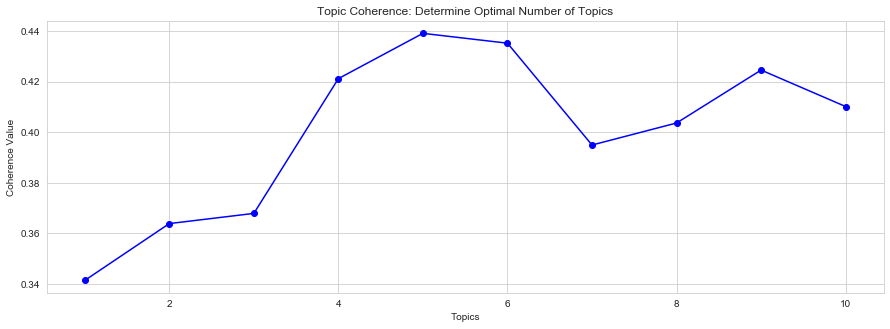

In [36]:
fig, axis = plt.subplots(1, 1, figsize=(15,5))

axis.plot(topic_range, coherence_values, 'bo-')
axis.set_xlabel('Topics') 
axis.set_ylabel('Coherence Value') 
axis.set_title('Topic Coherence: Determine Optimal Number of Topics')